# Méthodes

In [1]:
def filter_col_by_mising_data_pct(df, pct_min=0, pct_max=100):
    result = pd.DataFrame()
    print("Le DataFrame à filtrer présente", len(df), "lignes et", len(df.columns), "colonnes.")
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    print("La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de", pct_min, "% inclu à", pct_max, "% exclu.")
    # extraction des colonnes remplissant la condition de filtrage
    tot_list_col = round(df.isnull().mean()*100, 4).sort_values(ascending=False)
    tot_list_col = pd.DataFrame(tot_list_col, columns = ["%"])
    remain_list_col = tot_list_col.loc[(tot_list_col["%"] >= pct_min) & (tot_list_col["%"] < pct_max), :]
    nb_col_remained = len(remain_list_col)
    nb_col_removed = len(tot_list_col) - nb_col_remained
    print("Après filtrage, il reste", nb_col_remained, "colonnes dans le DataFrame.")
    print("Il y a eu suppression de", nb_col_removed, "colonnes, soit", round(nb_col_removed/len(tot_list_col)*100, 2), "% des colonnes.")
    
    # test sur le nb de colonnes restantes
    if len(remain_list_col) == 0:
        print("Le filtre est trop bas. Il n'y a plus de colonnes à exploiter.")
        return result
    
    # renvoyer le même dataset avec uniquement les colonnes filtrées
    result = df[remain_list_col.index]
    return result

In [2]:
def remove_empty_columns(df):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    print("Appel de la méthode filter_col_by_mising_data_pct() pour supprimer les colonnes vides.")
    result = filter_col_by_mising_data_pct(df)
    return result    

In [3]:
def split_data_num_categ(df):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

In [4]:
# pour afficher les pourcentages et les libellés pour les parts > 5%
limit_perc = 5
def show_perc(pct):
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

***
# II) Présentation générale du jeu de données

## 1) Exploration du dataset

### Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set()

### Chargement du dataset

Il y avait un problème de données à cheval sur plusieurs lignes. Un script a permis de corriger le problème. Voici le fichier corrigé en entrée.

In [6]:
# Le séparateur dans le dataset est la tabulation
raw_data = pd.read_csv("fr.openfoodfacts.org.products_c1.csv", encoding='utf-8', sep='\t')

/tmp/ipykernel_11730/2650904854.py:2: DtypeWarning: Columns (0,19,20,24,25,26,28,35,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("fr.openfoodfacts.org.products_c1.csv", encoding='utf-8', sep='\t')


In [7]:
print("Le dataset présente", raw_data.shape[0], "lignes et", raw_data.shape[1], "colonnes")
raw_data.head()

Le dataset présente 320749 lignes et 162 colonnes


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Etude préalable des données manquantes

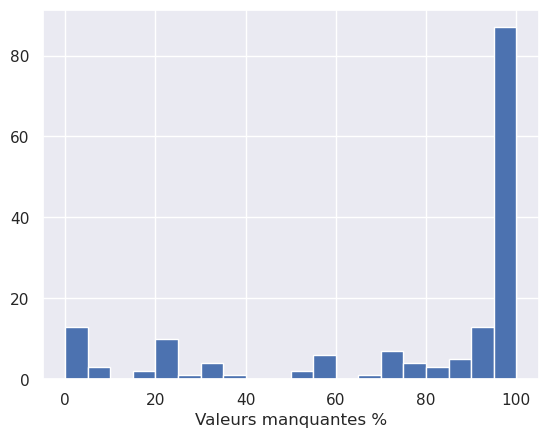

In [8]:
# on regarde la répartition des colonnes en fonction de la part de valeurs manquantes
valeurs_manquantes = round(raw_data.isnull().mean()*100, 4).sort_values(ascending=False)
missing_val_df = pd.DataFrame(valeurs_manquantes, columns = ["%"])
missing_val_df["%"].hist(bins=20)
plt.xlabel("Valeurs manquantes %")
plt.show()

In [9]:
miss_val_90 = missing_val_df.loc[missing_val_df["%"]>=95, :]
print("Les colonnes ayant plus de 95% de valeurs manquantes sont au nombre de", len(miss_val_90), "soit,", round(len(miss_val_90)/raw_data.shape[1]*100, 1), "% des colonnes.")

Les colonnes ayant plus de 95% de valeurs manquantes sont au nombre de 87 soit, 53.7 % des colonnes.


<AxesSubplot:>

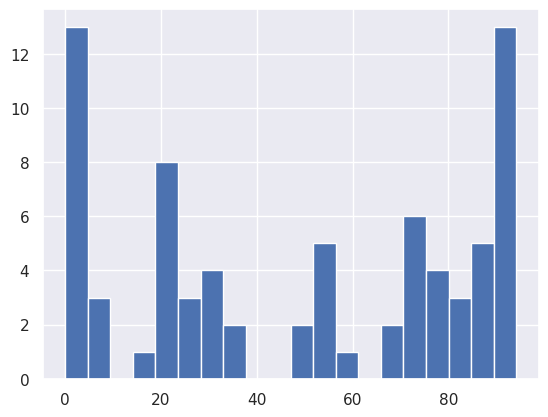

In [10]:
# En se concentrant sur les colonnes ayant plus de 95% de données renseignées
valeurs_manquantes = round(raw_data.isnull().mean()*100, 4).sort_values(ascending=False)
missing_val_df = pd.DataFrame(valeurs_manquantes, columns = ["%"])
missing_val_df.loc[missing_val_df["%"]<95, "%"].hist(bins=20)

### Description du dataset

In [11]:
# vérification des types de données
raw_data.dtypes

code                        object
url                         object
creator                     object
created_t                    int64
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

In [12]:
# On regare la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(raw_data)

Voici la répartition des colonnes par type de données :
numeric : 110 colonnes.
category : 52 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


In [13]:
print("Le dataset est réparti comme suit :")
print("Colonnes de type numérique :", len(data_num.columns), "soit,", round(len(data_num.columns)/len(raw_data.columns)*100, 1), "% des colonnes.")
print("Colonnes de type catégoriciel :", len(data_categ.columns), "soit,", round(len(data_categ.columns)/len(raw_data.columns)*100, 1), "% des colonnes.")

Le dataset est réparti comme suit :
Colonnes de type numérique : 110 soit, 67.9 % des colonnes.
Colonnes de type catégoriciel : 52 soit, 32.1 % des colonnes.


In [14]:
# nettoyage des données pour voir les outliers notamment
raw_data.describe()

,created_t,last_modified_t,cities,allergens_fr,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,3.207490e+05,3.207490e+05,0.0,0.0,0.0,248961.000000,248961.000000,0.0,248961.000000,0.0,...,49.000000,3046.000000,165.000000,948.000000,0.0,268.000000,221233.000000,221233.000000,0.0,0.0
mean,1.470622e+09,1.478938e+09,NaN,NaN,NaN,1.936384,0.019658,NaN,0.055246,NaN,...,6.425698,31.376615,15.412121,49.547785,NaN,341.700764,9.164736,9.057261,NaN,NaN
std,3.307000e+07,2.084030e+07,NaN,NaN,NaN,2.502319,0.140518,NaN,0.269203,NaN,...,2.047841,31.947699,3.753028,18.757932,NaN,425.211439,9.055796,9.183461,NaN,NaN
min,0.000000e+00,1.332368e+09,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,1.462984e+09,1.479389e+09,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,1.489058e+09,1.489062e+09,NaN,NaN,NaN,1.000000,0.000000,NaN,0.000000,NaN,...,7.200000,22.100000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,1.489079e+09,1.489093e+09,NaN,NaN,NaN,3.000000,0.000000,NaN,0.000000,NaN,...,7.400000,50.950000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN
max,1.492737e+09,1.492737e+09,NaN,NaN,NaN,31.000000,2.000000,NaN,6.000000,NaN,...,8.400000,100.000000,25.000000,100.000000,NaN,2842.000000,40.000000,40.000000,NaN,NaN


Le nombre de colonne est très important et certaines sont vide ou pas utiles pour notre étude.  
Voici néanmoins, leur répartition selon ces catégories : 
 - Identification : 
 - Target : pour le calcul de notre modèle
 - Obligatoire : ce sont les éléments qui sont obligatoirement sur les étiquettes des produits d'après les lois européennes
 - Possible : ce sont les éléments qui sont possiblement sur les étiquettes des produits d'après les lois européennes
 - Pertiente : ce sont les éléments que je trouve pertient pour notre étude
 - Vitamines : 
 - Sels minéraux : 

***
## 2) Nettoyage du dataset

### Suppression lignes sans nutri-score

Lors du nettoyage, nous devons prendre en compte l'objectif métier.  
Qualifier la qualité des produits.  
En observant le dataset, nous avons la possiblité d'utiliser la variable `nutrition-score-fr_100g` comme valeur cible.  
Nous pouvons alors supprimer toutes les lignes n'ayant pas de nutri-score de renseigné.

In [15]:
# le nutriscore sera notre target, donc on peut supprimer toutes les lignes n'ayant pas de nutriscore renseigné
data_w_target = raw_data.loc[raw_data["nutrition-score-fr_100g"].notnull(), :]
print("Il y a", raw_data.shape[0] - data_w_target.shape[0], "lignes sans nutri-score de renseigné, soit", round((1-data_w_target.shape[0]/raw_data.shape[0])*100, 2), "% des données.")
data_w_target.reset_index(drop=True)

Il y a 99516 lignes sans nutri-score de renseigné, soit 31.03 % des données.


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
1,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
3,16124,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055711,2017-03-09T10:35:11Z,1489055712,2017-03-09T10:35:12Z,Organic Muesli,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,NaN,NaN
4,16872,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055650,2017-03-09T10:34:10Z,1489055651,2017-03-09T10:34:11Z,Zen Party Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221228,9787461062105,http://world-fr.openfoodfacts.org/produit/9787...,usda-ndb-import,1489092300,2017-03-09T20:45:00Z,1489092300,2017-03-09T20:45:00Z,Natural Cassava,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN
221229,9847548283004,http://world-fr.openfoodfacts.org/produit/9847...,drmalabar,1437817626,2015-07-25T09:47:06Z,1442237848,2015-09-14T13:37:28Z,Tartines craquantes bio au sarrasin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,-4.0,NaN,NaN
221230,9900000000233,http://world-fr.openfoodfacts.org/produit/9900...,kiliweb,1491079938,2017-04-01T20:52:18Z,1491079939,2017-04-01T20:52:19Z,Amandes,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
221231,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,1367163039,2013-04-28T15:30:39Z,1371690556,2013-06-20T01:09:16Z,Thé vert Earl grey,thé bio équitable,50 g,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN


### Suppression colonnes 100% vides

Les colonnes étant complètement vides ne seront pas utilisées dans notre étude. Nous allons donc les supprimer à l'aide de la méthode développée spécialement pour cette étude.

In [16]:
# on appelle la méthode permettant de supprimer les colonnes vides
data_filt_100p = remove_empty_columns(data_w_target)

Appel de la méthode filter_col_by_mising_data_pct() pour supprimer les colonnes vides.
Le DataFrame à filtrer présente 221233 lignes et 162 colonnes.
La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de 0 % inclu à 100 % exclu.
Après filtrage, il reste 135 colonnes dans le DataFrame.
Il y a eu suppression de 27 colonnes, soit 16.67 % des colonnes.


### Sélection colonnes pertinentes

Toujours en gardant notre objectif de pouvoir qualifier les produits de ce dataset, nous pouvons en déduire 2 faits : 
 - certaines colonnes ne seront pas utiles du tout (date création, localisation géographiques...)
 - le contenu des étiquettes des produits sont régis par des lois et donc sont plus facilement présentes

Colonnes d'identification : 
- `code` : identifiant unique
- `product_name` : nom du produit
- `generic_name` : nom générique si le nom de base manque
- `nutrition_grade_fr` : nutri-score représenté par une lettre de A à E
Les autres colonnes de type catégoriciel ne sont soit pas pertienentes, soit à plus de 60% vides.

Colonnes avec des données obligatoirement sur les étiquettes d'après les lois européennes : 
- `energy_100g` : valeur énergétique du produit en kJ pour 100g
- `fat_100g` : teneur en matière grasse pour 100g
- `saturated-fat_100g` : teneur en matière grasse saturée pour 100g
- `carbohydrates_100g` : teneur en glucide pour 100g
- `sugars_100g` : teneur en sucre pour 100g
- `proteins_100g` : teneur en protéine pour 100g
- `salt_100g` : teneur en sel pour 100g

Colonnes avec des données potentiellement présentes sur les étiquettes d'après les lois européennes : 
- `monounsaturated-fat_100g` : teneur en matière grasse mono-insaturée pour 100g
- `polyunsaturated-fat_100g` : teneur en matière grasse poly-insaturée pour 100g
- `polyols_100g` : teneur en polyol (ou glycol) pour 100g
- `starch_100g` : teneur en amidon pour 100g
- `fiber_100g` : teneur en fibre pour 100g

Colonnes avec des données sur les vitamines potentiellement présentes sur les étiquettes d'après les lois européennes : 
- `vitamin-a_100g` : teneur en vitamine A pour 100g
- `vitamin-d_100g` : teneur en vitamine D pour 100g
- `vitamin-e_100g` : teneur en vitamine E pour 100g
- `vitamin-k_100g` : teneur en vitamine K pour 100g
- `vitamin-c_100g` : teneur en vitamine C pour 100g
- `vitamin-b1_100g` : teneur en vitamine B1 pour 100g
- `vitamin-b2_100g` : teneur en vitamine B2 pour 100g
- `vitamin-pp_100g` : teneur en vitamine PP (B3, Niacine) pour 100g
- `vitamin-b6_100g` : teneur en vitamine B6 pour 100g
- `vitamin-b9_100g` : teneur en vitamine B9 pour 100g
- `vitamin-b12_100g` : teneur en vitamine B12 pour 100g
- `biotin_100g` : teneur en Biotine (B8) pour 100g
- `pantothenic-acid_100g` : teneur en Acide panthothénique (B5) pour 100g

Colonnes avec des données sur les sels minéraux potentiellement présentes sur les étiquettes d'après les lois européennes : 
- `potassium_100g` : teneur en potassium pour 100g
- `chloride_100g` : teneur en chlorure pour 100g
- `calcium_100g` : teneur en calcium pour 100g
- `phosphorus_100g` : teneur en phosphore pour 100g
- `iron_100g` : teneur en fer pour 100g
- `magnesium_100g` : teneur en magnésium pour 100g
- `zinc_100g` : teneur en zinc pour 100g
- `copper_100g` : teneur en cuivre pour 100g
- `manganese_100g` : teneur en manganèse pour 100g
- `fluoride_100g` : teneur en fluor pour 100g
- `selenium_100g` : teneur en sélénium pour 100g
- `chromium_100g` : teneur en chrome pour 100g
- `molybdenum_100g` : teneur en molybdène pour 100g
- `iodine_100g` : teneur en iode pour 100g

Colonnes qui ont une importances sur la qualifaication des produits : 
- `additives_n` : nombre d'additifs dans le produit
- `ingredients_from_palm_oil_n` : nombre d'ingrédients issus de l'huile de palme
- `ingredients_that_may_be_from_palm_oil_n` : nombre d'ingrédients propablement issus de l'huile de palme
- `fruits-vegetables-nuts_100g` : part de fruits, légumes et/ou famille de noix pour 100g

In [ ]:
col_id = ['code', 'product_name', 'generic_name', 'nutrition_grade_fr', "pnns_groups_1", "pnns_groups_2", "countries_fr"]
col_target = ['nutrition-score-fr_100g']
col_mandatory = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g']
col_possible = ['monounsaturated-fat_100g', 'polyunsaturated-fat_100g', "polyols_100g", "starch_100g", "fiber_100g"]
col_pertinents = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'fruits-vegetables-nuts_100g']
col_vitamins = ['vitamin-a_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g',
                'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'vitamin-b12_100g', 'biotin_100g',
                 'pantothenic-acid_100g']
col_minerals = ['potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g',
                 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g', 'selenium_100g', 'chromium_100g',
                 'molybdenum_100g', 'iodine_100g']
print("D'après les lois européennes, il y a", len(col_mandatory), "colonnes que l'on retrouve obligatoirement sur une étiquette.")
print("Sur cette même étiquette, il y a optionnellement", len(col_possible), "autres colonnes de base.")
print("Dans les données optionnelles, il y a aussi", len(col_vitamins), "colonnes avec les vitamines.")
print("Et il y a", len(col_minerals), "colonnes avec les sels minéraux.")
print("Pour finir, il y a", len(col_pertinents), "colonnes pertinentes pour notre étude.")
col_to_keep = col_id + col_target + col_mandatory + col_possible + col_pertinents + col_vitamins + col_minerals
print("On va donc travailler exclusivement avec ces", len(col_to_keep), "colonnes, soit", round(len(col_to_keep)/len(raw_data.columns)*100, 2), "% des colonnes.")
data_col_keep = data_filt_100p[col_to_keep]
print("Après filtrage, il reste", len(data_col_keep.columns), "colonnes dans le DataFrame.")

D'après les lois européennes, il y a 7 colonnes que l'on retrouve obligatoirement sur une étiquette.
Sur cette même étiquette, il y a optionnellement 5 autres colonnes de base.
Dans les données optionnelles, il y a aussi 13 colonnes avec les vitamines.
Et il y a 14 colonnes avec les sels minéraux.
Pour finir, il y a 4 colonnes pertinentes pour notre étude.
On va donc travailler exclusivement avec ces 51 colonnes, soit 31.48 % des colonnes.
Après filtrage, il reste 51 colonnes dans le DataFrame.


### Suppression lignes dupliquées

Suite à la sélection des colonnes pour notre étude, nous pouvons maintenant traiter les lignes dupliquées.

In [18]:
# identification et suppressions des lignes dupliquées
nb_lignes_dupli = data_col_keep.duplicated().sum()
print("Il y a", nb_lignes_dupli, "lignes dupliquées dans ce dataset, soit", round(nb_lignes_dupli/len(data_col_keep)*100, 3), "% du dataset.")
data_dupli_drop = data_col_keep.drop_duplicates().reset_index(drop=True)
print("On a supprimé les lignes dupliquées. Il reste", len(data_dupli_drop), "lignes dans le dataset.")

Il y a 10 lignes dupliquées dans ce dataset, soit 0.005 % du dataset.
On a supprimé les lignes dupliquées. Il reste 221223 lignes dans le dataset.


***
### Shape du dataset fixe

Le nettoyage sur la structure du dataset est maintenant terminé. Les nombres de colonnes et de lignes resteront fixes.

In [29]:
data = data_dupli_drop
print("Notre dataset d'étude présente", data.shape[0], "lignes et", data.shape[1], "colonnes")
print("Par rapport à notre dataset brut, on a gardé", round(data.shape[0]/raw_data.shape[0]*100, 2), "% de lignes et", round(data.shape[1]/raw_data.shape[1]*100, 2), "% de colonnes.")
print("Par rapport à notre dataset brut, on a supprimé", round((1-data.shape[0]/raw_data.shape[0])*100, 2), "% de lignes et", round((1-data.shape[1]/raw_data.shape[1])*100, 2), "% de colonnes.")

Notre dataset d'étude présente 221223 lignes et 51 colonnes
Par rapport à notre dataset brut, on a gardé 68.97 % de lignes et 31.48 % de colonnes.
Par rapport à notre dataset brut, on a supprimé 31.03 % de lignes et 68.52 % de colonnes.


### Séparation données numériques et catégoricielles

In [20]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(data_dupli_drop)

Voici la répartition des colonnes par type de données :
numeric : 44 colonnes.
category : 7 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


### Valeurs manquantes

In [21]:
# voici la répartition des données manquantes pour les données catégoricielles
miss_categ = round(data[data_categ.columns].isnull().mean()*100, 4).sort_values(ascending=False)
miss_categ_df = pd.DataFrame(miss_categ, columns = ["%"])
print(miss_categ_df)

                          %
generic_name        82.3847
pnns_groups_1       72.0522
pnns_groups_2       72.0038
product_name         1.2417
countries_fr         0.0258
code                 0.0000
nutrition_grade_fr   0.0000


On remplit le colonne `product_name` comme suit : 
- si `generic_name` a une valeur, on lui attribue
- sinon, on prend la valeur dans `code`

In [22]:
# si pas de product name, prendre generic name
mask_gen_to_prod = (data["product_name"].isnull()) & (data["generic_name"].notnull())
data.loc[mask_gen_to_prod, "product_name"] = data["generic_name"]
# sinon, prendre code
mask_code_to_prod = (data["product_name"].isnull()) & (data["code"].notnull())
data.loc[mask_code_to_prod, "product_name"] = data["code"]

***

In [23]:
# voici la répartition des données manquantes pour les données catégoricielles
miss_num = round(data[data_num.columns].isnull().mean()*100, 4).sort_values(ascending=False)
miss_num_df = pd.DataFrame(miss_num, columns = ["%"])
print(miss_num_df)

                                               %
molybdenum_100g                          99.9968
chromium_100g                            99.9928
fluoride_100g                            99.9788
chloride_100g                            99.9711
iodine_100g                              99.8965
starch_100g                              99.8861
biotin_100g                              99.8748
polyols_100g                             99.8219
vitamin-k_100g                           99.6063
selenium_100g                            99.5715
vitamin-e_100g                           99.4589
manganese_100g                           99.3183
pantothenic-acid_100g                    99.2103
copper_100g                              99.0878
fruits-vegetables-nuts_100g              98.7221
zinc_100g                                98.4075
vitamin-b12_100g                         98.1530
vitamin-b9_100g                          97.7353
magnesium_100g                           97.5712
phosphorus_100g     

On fait l'approximation de mettre toutes les valeurs numériques à 0 car si elles ne sont pas renseignées, c'est souvent parce qu'elles n'existent tout simplement pas sur l'étiquette.  
Une différente approche renseignerait des valeurs arbitraires.

In [24]:
# toutes les valeurs numériques ont remplies à 0
for col in data_num.columns:
    data[col].fillna(0, inplace=True)

### Outliers

In [25]:
data[data_num.columns].describe()

,nutrition-score-fr_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,...,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g
count,221223.000000,2.212230e+05,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,...,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,2.212230e+05,221223.000000,2.212230e+05,2.212230e+05,2.212230e+05
mean,9.164639,1.195217e+03,12.309933,4.965493,30.596926,15.010375,7.768934,1.638742,0.659043,0.455032,...,0.001888,0.011057,0.000116,0.000051,0.000020,7.376783e-07,0.000016,1.379204e-07,1.069509e-09,3.157486e-07
std,9.055873,6.986475e+03,15.967228,7.657740,28.617299,21.175718,8.123507,137.352639,4.159129,2.895605,...,0.134368,2.010005,0.010429,0.037997,0.002372,1.553570e-04,0.007594,6.378419e-05,2.646401e-07,2.458445e-05
min,-15.000000,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,-3.570000,0.000000,0.000000,0.000000,...,-0.000260,0.000000,0.000000,-6.896552,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,4.500000e+02,0.000000,0.000000,4.700000,1.270000,1.900000,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,10.000000,1.192000e+03,5.360000,1.790000,19.610000,5.000000,5.700000,0.645160,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,16.000000,1.715000e+03,20.000000,7.140000,57.140000,23.035000,10.710000,1.361440,0.000000,0.000000,...,0.001290,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
max,40.000000,3.251373e+06,714.290000,550.000000,209.380000,3520.000000,430.000000,64312.800000,557.140000,75.000000,...,50.000000,657.143000,4.000000,16.483516,0.700000,5.000000e-02,3.571429,3.000000e-02,1.040000e-04,5.000000e-03


On observe différents outliers.  
Concernant les valeurs négatives, seul le nutri-score peut l'être. Pour toutes les autres, on remplace la valeur négative par zéro.  
Concernant les valeurs maximum, les taux pour 100 g ne devraient pas dépasser 100. C'est une certitude pour les composants de base. En revanche, pour les vitamines et les sels minéraux, il est possible que l'unité de mesure soit le µg. Une valeur supérieur à 100 est donc envisageable. Nous les laisserons donc ainsi.

In [26]:
# toutes les valeurs négatives, sauf le nutriscore seront calées à 0
col_outliers_1 = col_mandatory + col_possible + col_pertinents + col_vitamins + col_minerals
nb_num_neg = 0
for col in col_outliers_1:
    temp_nb_num_neg = data.loc[data[col]<0, :]
    nb_num_neg += len(temp_nb_num_neg)
    data.loc[data[col]<0, col] = 0  
print("Toutes les valeurs négatives sont calées à 0, exceptée le nutri-score. Elles représentent", nb_num_neg, "valeurs, soit", round(nb_num_neg/len(data)*100, 3), "% du dataset d'étude.")

# toutes les valeurs supérieures à 100, sauf les vitamines et minéraux (unités en µg parfois) et la valeur énergétique
nb_num_sup_cent_ok = 0
col_outliers_2 = col_mandatory[1:] + col_possible + col_pertinents
for col in col_outliers_2:
    temp_nb_num_sup_cent_ok = data.loc[data[col]>100, :]
    nb_num_sup_cent_ok += len(temp_nb_num_sup_cent_ok)
    data.loc[data[col]>100, col] = 100
print("Toutes les valeurs supérieures à 100 sont calées à 100 pour les composants autre que les vitamines et les sels minéraux, ainsi que la valeur énergétique. Elles représentent", nb_num_sup_cent_ok, "valeurs, soit", round(nb_num_sup_cent_ok/len(data)*100, 2), "% du dataset d'étude.")

Toutes les valeurs négatives sont calées à 0, exceptée le nutri-score. Elles représentent 10 valeurs, soit 0.005 % du dataset d'étude.
Toutes les valeurs supérieures à 100 sont calées à 100 pour les composants autre que les vitamines et les sels minéraux, ainsi que la valeur énergétique. Elles représentent 82 valeurs, soit 0.04 % du dataset d'étude.


In [27]:
# outliers qu'on laissera ainsi à cause des différentes unités de mesure
nb_num_sup_cent_maybe = 0
col_outliers_3 = col_vitamins + col_minerals
for col in col_outliers_3:
    temp_nb_num_sup_cent_maybe = data.loc[data[col]>100, :]
    nb_num_sup_cent_maybe += len(temp_nb_num_sup_cent_maybe)
print("Il y a cependant, des valeurs supérieures à 100 qu'on laissera ainsi. Elles représentent", nb_num_sup_cent_maybe, "valeurs, soit", round(nb_num_sup_cent_maybe/len(data)*100, 3), "% du dataset d'étude.")    

Il y a cependant, des valeurs supérieures à 100 qu'on laissera ainsi. Elles représentent 17 valeurs, soit 0.008 % du dataset d'étude.


Concernant la valeur énergétique, il existe une valeur maximale possible, 3700 kJ. Nous calerons donc toutes les valeurs supérieurs à celle-ci.

In [28]:
energy_max = 3700
nb_energy_sup_max = len(data.loc[data["energy_100g"]>energy_max, :])
print("Nous modifions la valeur de l'énergie pour", nb_energy_sup_max, "lignes, soit", round(nb_energy_sup_max/len(data)*100, 2), "% du dataset d'étude.")    
data.loc[data["energy_100g"]>energy_max, "energy_100g"] = energy_max

Nous modifions la valeur de l'énergie pour 442 lignes, soit 0.2 % du dataset d'étude.
